# Transformer Model Medium Size

Trained with Google TPU v2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# write where you want to save all your files
root = "/content/drive/MyDrive/Franklin_JacobsonGoogleDrive/ActigraphyTransformer/Modeling/Transformer_Basic"

# Imports and **Connect To TPU**

In [ ]:
!pip install pyarrow fastparquet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 62.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 78.9 MB/s eta 0:00:00


In [ ]:
# @title Importing

# Packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import tensorflow as tf
import os
from IPython.display import clear_output

# Sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

# Keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
#from keras.layers.embeddings import Embedding
from keras.metrics import AUC

# Tf
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import random

# Import Layers
from keras.layers import ConvLSTM2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Activation
from keras.layers import TimeDistributed
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import MaxPooling3D

In [ ]:
## SEEDS

# Hard Code Random Seeds.
r1 = 0
r2 = 1

# Set Random Seed
random.seed(r1)
tf.random.set_seed(r2)

In [ ]:
#@title Connect to TPU
print("TensorFlow version:", tf.__version__)

# Connect to the TPU cluster or fall back to CPU/GPU
try:
  resolver = tf.distribute.cluster_resolver.TPUClusterResolver()  # Tries to connect to the TPU
  tf.config.experimental_connect_to_cluster(resolver)
  tf.tpu.experimental.initialize_tpu_system(resolver)
  strategy = tf.distribute.TPUStrategy(resolver)
  devices = tf.config.list_logical_devices('TPU')
  print('TPU devices:', devices)
except ValueError:
  print("Could not connect to TPU; using CPU/GPU strategy instead.")
  strategy = tf.distribute.get_strategy()

# Example computation using the strategy
with strategy.scope():
  a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
  b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])

  @tf.function
  def matmul_fn(x, y):
    return tf.matmul(x, y)

  z = strategy.run(matmul_fn, args=(a, b))

print(z)

TensorFlow version: 2.15.0
TPU devices: [LogicalDevice(name='/device:TPU:0', device_type='TPU'), LogicalDevice(name='/device:TPU:1', device_type='TPU'), LogicalDevice(name='/device:TPU:2', device_type='TPU'), LogicalDevice(name='/device:TPU:3', device_type='TPU'), LogicalDevice(name='/device:TPU:4', device_type='TPU'), LogicalDevice(name='/device:TPU:5', device_type='TPU'), LogicalDevice(name='/device:TPU:6', device_type='TPU'), LogicalDevice(name='/device:TPU:7', device_type='TPU')]
PerReplica:{
  0: tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32),
  1: tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32),
  2: tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32),
  3: tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32),
  4: tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32),
  5: tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32),
  6: tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32),
  7: tf.

# Prepare Data

Might need this

In [ ]:
# !pip install pyarrow fastparquet

In [ ]:
import pandas as pd
data_all = pd.read_parquet('/content/drive/MyDrive/Franklin_JacobsonGoogleDrive/ActigraphyTransformer/Data/Actigraphy/[smoothed]WideSeqnActi_AndMeds_ALL.parq')

# Choose Variable

In [ ]:
# Spit actigraphy X and then y
chosen_y = data_all['Taking_Benzodiazepine']
chosen_X = data_all.drop(columns=['Taking_SSRI', 'Taking_Benzodiazepine', 'Taking_Psychotropic'])

Make X

In [ ]:
# Load Data X -------
Wide_X = chosen_X
data_wide = Wide_X

# Standard Scalar
scaler = StandardScaler()
scaler.fit(data_wide)
data_wide = scaler.transform(data_wide)

# Convert DF to array
data_wide = np.array(data_wide)

Make Y

In [ ]:
# Load Data Y
Y = chosen_y

# Make y array as well
y = np.hstack(np.asarray(Y)).reshape(len(Y),1)

# Split Data

In [ ]:
from sklearn.model_selection import train_test_split

# First, split into train and temp (this temp will be split into validation and test)
X_train, X_temp, y_train, y_temp = train_test_split(data_wide, y, test_size=0.2, stratify=y, random_state=19)

# Now, split the temp data into validation and test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=19)  # Splitting the temp equally

# Reshape Train, Validation and Test
n_participants_train = X_train.shape[0]
n_participants_val = X_val.shape[0]
n_participants_test = X_test.shape[0]
n_timesteps = X_train.shape[1]
n_features = 1

# Dimentions
n_steps, n_length, n_width = 7, 24, 60
n_features = 1

# Reshape Train and Test
X_train = X_train.reshape((X_train.shape[0], n_steps,odel, n_features))
X_test = X_test.reshape((X_test.shape[0], n_steps, n_length, n_width, n_features))
X_val = X_val.reshape((X_val.shape[0], n_steps, n_length, n_width, n_features))


Basic Data Analysis

In [ ]:
# Shape Analysis
print("shape of X:", data_wide.shape)
print("shape of y:", y.shape)
# Class Analysis
benzoUse = int(sum(y))
total = int(len(y))
benzoNoUse = int(total-benzoUse)

print("Benzo Use:", benzoUse, "participants")
print("Benzo No Use:", benzoNoUse, "participants")

shape of X: (29307, 10080)
shape of y: (29307, 1)
Benzo Use: 694 participants
Benzo No Use: 28613 participants


<ipython-input-13-9e0b4d46660a>:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  benzoUse = int(sum(y))


# MODELING

In [ ]:
# Model Structure
def create_model():
  model = Sequential()

  # Conv Layers
  model.add(ConvLSTM2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=(n_steps, n_length, n_width, n_features) ,return_sequences=True) )
  model.add(Activation('relu'))
  model.add(MaxPooling3D(pool_size=(1, 2, 2)))
  model.add(ConvLSTM2D(filters=64, kernel_size=(2, 2), padding='valid', return_sequences= False))

  # Feed Forward Layers
  model.add(Dropout(0.2))
  model.add(Flatten())
  model.add(tf.keras.layers.Dropout(rate=0.2))
  model.add(Dense(100, activation='relu'))
  model.add(tf.keras.layers.Dense(1, activation='sigmoid')) #Sigmoid b/c our outcome is binary.

  return model

# Training & Evaluation

In [ ]:
# Params ----------
# Balance Weights
class_weights = {0: (benzoUse/total),  # Custom Setting Class Weights
                1: (benzoNoUse/total)}

# Early Stopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_auc',
                                            patience=250,
                                            restore_best_weights=True,
                                            )

In [ ]:
# Compile the model -----
with strategy.scope():
  train_model = create_model()
  train_model.compile(
    # Metrics
    loss= tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics= tf.keras.metrics.AUC(name='auc'),
    # Optimizer
    optimizer= tf.keras.optimizers.Adam(
      learning_rate=0.00001,
      beta_1=0.9,
      beta_2=0.999,
      epsilon=1e-07,
      amsgrad=False
))

train_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 7, 20, 56, 32)     105728    
                                                                 
 activation (Activation)     (None, 7, 20, 56, 32)     0         
                                                                 
 max_pooling3d (MaxPooling3  (None, 7, 10, 28, 32)     0         
 D)                                                              
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 9, 27, 64)         98560     
                                                                 
 dropout (Dropout)           (None, 9, 27, 64)         0         
                                                                 
 flatten (Flatten)           (None, 15552)             0         
                                                        

In [ ]:
# Train the Model -----
history = train_model.fit(
      X_train, y_train,
      epochs= 5000,
      batch_size= 64,
      validation_data = (X_val, y_val),
      shuffle=False,
      class_weight=class_weights,
      callbacks = [callback],
      verbose = 2)

Epoch 1/5000
367/367 - 66s - loss: 0.0318 - auc: 0.5835 - val_loss: 0.6435 - val_auc: 0.5882 - 66s/epoch - 181ms/step
Epoch 2/5000
367/367 - 27s - loss: 0.0312 - auc: 0.5890 - val_loss: 0.6595 - val_auc: 0.6155 - 27s/epoch - 74ms/step
Epoch 3/5000
367/367 - 27s - loss: 0.0310 - auc: 0.5934 - val_loss: 0.6756 - val_auc: 0.5974 - 27s/epoch - 74ms/step
Epoch 4/5000
367/367 - 27s - loss: 0.0309 - auc: 0.5933 - val_loss: 0.6811 - val_auc: 0.5877 - 27s/epoch - 73ms/step
Epoch 5/5000
367/367 - 27s - loss: 0.0309 - auc: 0.5906 - val_loss: 0.6830 - val_auc: 0.6327 - 27s/epoch - 74ms/step
Epoch 6/5000
367/367 - 27s - loss: 0.0308 - auc: 0.5921 - val_loss: 0.6832 - val_auc: 0.6165 - 27s/epoch - 74ms/step
Epoch 7/5000
367/367 - 27s - loss: 0.0308 - auc: 0.5920 - val_loss: 0.6820 - val_auc: 0.6079 - 27s/epoch - 74ms/step
Epoch 8/5000
367/367 - 27s - loss: 0.0307 - auc: 0.5911 - val_loss: 0.6820 - val_auc: 0.5917 - 27s/epoch - 74ms/step
Epoch 9/5000
367/367 - 27s - loss: 0.0307 - auc: 0.5939 - val_l

In [ ]:
# Evaluate the model on the Validation Data
val_loss, val_auc = train_model.evaluate(X_val, y_val, verbose=2)

# Print the results
print("Val Loss:", val_loss)
print("Val AUC:", val_auc)
print(" ") # space

# Evaluate the model on the Test Data
test_loss, test_auc = train_model.evaluate(X_test, y_test, verbose=2)

# Print the results
print("Test Loss:", test_loss)
print("Test AUC:", test_auc)

92/92 - 2s - loss: 0.5886 - auc: 0.6808 - 2s/epoch - 22ms/step
Val Loss: 0.5885692834854126
Val AUC: 0.6807847619056702
 
92/92 - 2s - loss: 0.5916 - auc: 0.7025 - 2s/epoch - 23ms/step
Test Loss: 0.5915742516517639
Test AUC: 0.7024741172790527


# Model Introspection

AUC OVER EPOCHS

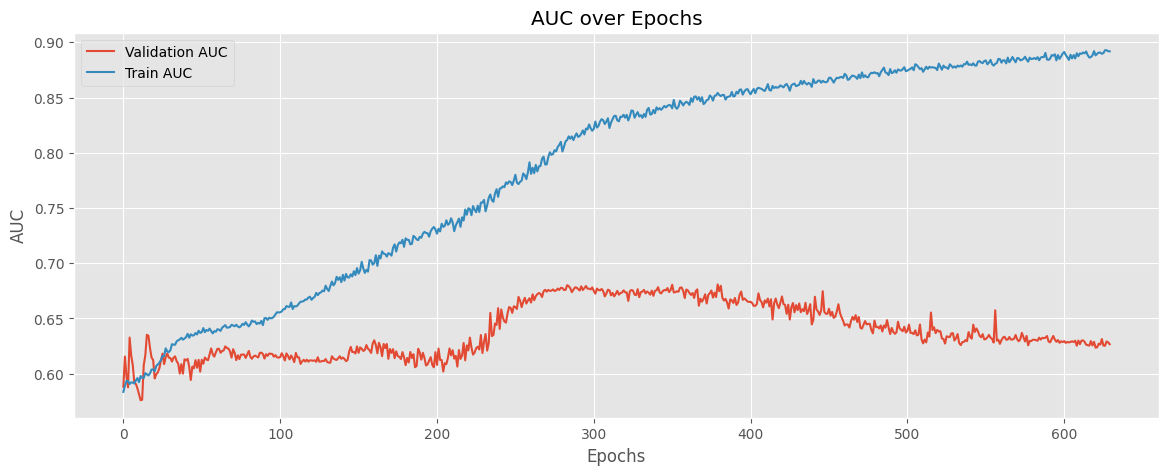

In [ ]:
# Style Sheet
plt.style.use('ggplot')

plt.figure(figsize=(14,5))
plt.title("AUC over Epochs")
plt.ylabel("AUC")
plt.xlabel("Epochs")
plt.plot(history.history['val_auc'], label='Validation AUC')
plt.plot(history.history['auc'], label='Train AUC')
plt.legend()